# Imports and setup

In [1]:
from torch import nn, optim
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms
from facenet_pytorch import InceptionResnetV1
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
import matplotlib.pyplot as plt
import os

from pytorch_metric_learning.miners import BatchHardMiner
from pytorch_metric_learning.losses import TripletMarginLoss

import lpips
import time

import kagglehub


c:\dev\ProjetImage\Face-Swap-M2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import utils
import dataloader

### Check si on peut utiliser cuda

In [3]:
print("Cuda compatible : ", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda compatible :  False


### classe pour mesurer le temps d'entrainement restant

In [4]:
class ETA:
    t = []
    @staticmethod
    def fmt(s):
        s=int(s);m,s=divmod(s,60);h,m=divmod(m,60)
        return f"{h}h {m}m {s}s" if h else f"{m}m {s}s" if m else f"{s}s"

    def __init__(self,total,win=50):
        self.total=total;self.win=win;self.step=0

    def update(self):
        ETA.t.append(time.time())
        ETA.t=ETA.t[-self.win:]
        self.step+=1

    def eta(self):
        if self.step<2:return 0
        d=[ETA.t[i]-ETA.t[i-1] for i in range(1,len(ETA.t))]
        return (self.total-self.step)*(sum(d)/len(d))
    def print(self):
        print(ETA.fmt(self.eta()))


# Chargement du dataset perso

In [5]:
IMAGE_SIZE = 128
NB_IMAGES = 10

In [6]:
train_dataset, test_dataset, nb_classes = dataloader.make_dataset("../data/Face-Swap-M2-Dataset/dataset/smaller", NB_IMAGES, IMAGE_SIZE, 0.8, crop_faces=False)


Building dataset 



# CelebA

In [47]:


# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

for root, dirs, files in os.walk(path):
    print(f"Dossier: {root}")
    print(f"Sous-dossiers: {dirs}")
    print(f"Fichiers (premiers 5): {files[:5]}")
    break



Path to dataset files: C:\Users\timothée\.cache\kagglehub\datasets\jessicali9530\celeba-dataset\versions\2
Dossier: C:\Users\timothée\.cache\kagglehub\datasets\jessicali9530\celeba-dataset\versions\2
Sous-dossiers: ['img_align_celeba']
Fichiers (premiers 5): ['list_attr_celeba.csv', 'list_bbox_celeba.csv', 'list_eval_partition.csv', 'list_landmarks_align_celeba.csv']


In [ ]:
print("Path to dataset files:", path)

In [48]:


from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader, Subset
import random

# Définir les transformations pour redimensionner les images à 64x64
transform = Compose([
    Resize((128, 128)),  # Redimensionner les images à 64x64
    ToTensor(),        # Convertir en tenseur PyTorch
    Normalize((0.5,), (0.5,))  # Normaliser les pixels entre -1 et 1
])

# Charger le dataset complet
dataset_path = "C:\\Users\\timothée\\.cache\\kagglehub\\datasets\\jessicali9530\\celeba-dataset\\versions\\2"
human_faces_dataset = ImageFolder(root=dataset_path, transform=transform)

# Réduire à 10% du dataset
dataset_size = len(human_faces_dataset)
subset_size = int(0.05 * dataset_size)
indices = random.sample(range(dataset_size), subset_size)
subset_dataset = Subset(human_faces_dataset, indices)

# Diviser le sous-dataset en train/test
train_size = int(0.8 * len(subset_dataset))
test_size = len(subset_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(subset_dataset, [train_size, test_size])

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Nombre d'images dans le sous-dataset : {len(subset_dataset)}")
print(f"Nombre d'images dans le train set : {len(train_dataset)}")
print(f"Nombre d'images dans le test set : {len(test_dataset)}")



Nombre d'images dans le sous-dataset : 10129
Nombre d'images dans le train set : 8103
Nombre d'images dans le test set : 2026


# Data Augmentation

In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)
])

class TransformedTensorDataset(Dataset):
    def __init__(self, tensor_dataset, transform=None):
        self.dataset = tensor_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

train_dataset = TransformedTensorDataset(train_dataset, transform=data_transform)
test_dataset = TransformedTensorDataset(test_dataset, transform=None)


# Paramètres

In [8]:

EMBEDDING_SIZE = 64
BATCH_SIZE = 32

EPOCHS = 100

In [49]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [50]:
for images, labels in train_loader:
    print("Batch shape:", images.shape)
    print("Min pixel value:", images.min().item())
    print("Max pixel value:", images.max().item())
    print("Mean pixel value:", images.mean().item())
    break

Batch shape: torch.Size([32, 3, 128, 128])
Min pixel value: -1.0
Max pixel value: 1.0
Mean pixel value: -0.034070778638124466


In [51]:
print(f"train samples: {len(train_dataset)}, test samples: {len(test_dataset)}, nb_classes: {nb_classes}")

class_counts = np.bincount([label for _, label in train_dataset])
for cls, count in enumerate(class_counts):
    print(f"train Class {cls}: {count} samples")

class_counts = np.bincount([label for _, label in test_dataset])
for cls, count in enumerate(class_counts):
    print(f"Test Class {cls}: {count} samples")

images, labels = next(iter(train_loader))
images = images.cpu()
labels = labels.cpu().numpy()

n = min(8, images.size(0))
imgs = images[:n]
labs = labels[:n]

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i, ax in enumerate(axs):
    if i < n:
        img = imgs[i].permute(1, 2, 0).numpy()
        mi, ma = img.min(), img.max()
        img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
        ax.imshow(img_disp)
        ax.set_title(f"label: {labs[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

train samples: 8103, test samples: 2026, nb_classes: 10


KeyboardInterrupt: 

# Définition des modèles

In [ ]:

class Embedder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc = nn.Linear(16 * (IMAGE_SIZE // 4) * (IMAGE_SIZE // 4), EMBEDDING_SIZE)

    def forward(self, x):
        res = self.conv(x)
        res = torch.flatten(res, 1)
        res = self.fc(res)
        res = F.normalize(res, p=2, dim=1)
        return res


class Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.fc = nn.Linear(EMBEDDING_SIZE, num_classes)
    def forward(self, x):
        return self.fc(x)
    

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(EMBEDDING_SIZE, 128, kernel_size=4, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),

        )

    def forward(self, x):
        res = x.unflatten(1, (EMBEDDING_SIZE, 1, 1))
        res = self.decoder(res)
        return res




# Embedding

## Entrainement

In [ ]:
faceEmbedder = Embedder().to(device)

model_parameters = filter(lambda p: p.requires_grad, faceEmbedder.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Embedder has {params} parameters")

triplet_loss = TripletMarginLoss(margin=1.0)
miner = BatchHardMiner()
optimizer = optim.Adam(faceEmbedder.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

final_embedder_loss = 0.0

train_losses = []
val_losses = []

faceEmbedder.train()
for epoch in range(200):

    total_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        #anchor_idx, positive_idx, negative_idx = utils.get_triplets(labels)
        #anchors = output[anchor_idx]
        #positives = output[positive_idx]
        #negatives = output[negative_idx]
        #loss = triplet_loss(anchors, positives, negatives)

        triplets = miner(output, labels)

        loss = triplet_loss(output,labels, triplets)

        
        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    total_loss = total_loss / len(train_loader)
    train_losses.append(total_loss)

    faceEmbedder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = faceEmbedder(images)
            #anchor_idx, positive_idx, negative_idx = utils.get_triplets(labels)

            #anchors = output[anchor_idx]
            #positives = output[positive_idx]
            #negatives = output[negative_idx]
            #loss = triplet_loss(anchors, positives, negatives)

            triplets = miner(output, labels)

            loss = triplet_loss(output,labels, triplets)

            val_loss += loss.item()

    val_loss = val_loss / len(test_loader)
    #val_losses.append(val_loss)

    print(f"Epoch {epoch+1}, Training Loss: {total_loss:.4f}, Validation Loss: {val_loss:.4f}")
    final_embedder_loss = total_loss
    faceEmbedder.train()


In [ ]:
torch.save(faceEmbedder.state_dict(), f"embedder_150.pth")

## Analyse

In [ ]:
plt.figure()
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Calcul tous les embeddings

In [ ]:
faceEmbedder.eval()
embeddings = []
avg_embeddings = []
with torch.no_grad():
    for images, labels in train_loader:
        #print(labels)
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        for i in range(output.size(0)):
            embeddings.append([output[i].cpu().tolist(), labels[i].cpu().item()])

    emb_np = np.array([item[0] for item in embeddings])
    lab_np = np.array([item[1] for item in embeddings])



    for cls in range(nb_classes):
        idx = np.where(lab_np == cls)[0]
        avg_emb = emb_np[idx].mean(axis=0)

        avg_embeddings.append(avg_emb)

        print(f"classe {cls}: avg embedding = {avg_emb.tolist()}")

In [ ]:
faceEmbedder.eval()

misclassified_images = []
true_labels = []
predicted_labels = []

avg_embeddings = torch.Tensor(avg_embeddings).to(device)

with torch.no_grad():
    for images, labels in DataLoader(test_dataset, batch_size=1):
        images = images.to(device)
        labels = labels.to(device)

        output = faceEmbedder(images)

        min_dist = math.inf
        i_min = -1
        for i in range(len(avg_embeddings)):
            d = torch.dist(output[0], avg_embeddings[i])
            if d.item() < min_dist:
                i_min = i
                min_dist = d.item()

        if i_min != labels[0].item():
            misclassified_images.append(images[0].cpu())
            true_labels.append(labels[0].item())
            predicted_labels.append(i_min)


n = len(misclassified_images)
cols = 4
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axs = axs.flatten()

for i, ax in enumerate(axs):
    ax.axis("off")
    if i < n:
        img = misclassified_images[i].permute(1, 2, 0).numpy()
        mi, ma = img.min(), img.max()
        img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
        ax.imshow(img_disp)
        ax.set_title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
plt.tight_layout()
plt.show()


### Plot embeddings

In [ ]:
def plot_embeddings():
    embeddings_np = np.array([e[0] for e in embeddings])
    labels_np = np.array([e[1] for e in embeddings])

    pca = PCA(n_components=2) #reduction en 2D
    reduced_embeddings = pca.fit_transform(embeddings_np)

    plt.figure(figsize=(10, 10))
    for label in np.unique(labels_np):
        idx = labels_np == label
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"classe {label}")

    plt.title("embeddings")
    plt.legend()
    plt.grid(True)
    plt.show()



plot_embeddings()

# Classifieur

## Entrainement

In [ ]:

classifier = Classifier(nb_classes).to(device)
crossLoss = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.0005)

final_classifier_loss = [0.0,0.0]

losses = []

faceEmbedder.eval()
for epoch in range(1250):
    total_loss = 0.0
    classifier.train()
    for images, labels in train_loader:
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        output = classifier(embeded)
        loss = crossLoss(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()


    #test avec le set de validation
    classifier.eval()
    total_eval_loss = 0.0
    for images, labels in test_loader:
        #images = torch.flatten(images, 1)
        images = images.to(device)
        labels = labels.to(device)

        embeded = faceEmbedder(images)

        output = classifier(embeded)
        loss = crossLoss(output, labels)

        #metrics
        total_eval_loss += loss.item()


    total_loss = total_loss / len(train_loader)
    total_eval_loss = total_eval_loss / len(test_loader)
    print(f"Epoch {epoch+1}, training loss: {total_loss:.4f}, test loss: {total_eval_loss:.4f}")

    losses.append((total_loss, total_eval_loss))

    final_classifier_loss[0] = total_loss
    final_classifier_loss[1] = total_eval_loss



#print("Classifier final train loss : ", final_classifier_loss[0], " test loss : ", final_classifier_loss[1])

## Analyse

In [ ]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

### Plot la matrice de confusion et accuracy

In [ ]:
def plot_confusion_matrix():
    classifier.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            #images = torch.flatten(images, 1)
            images = images.to(device)
            labels = labels.to(device)

            embeded = faceEmbedder(images)
            output = classifier(embeded)
            predictions = torch.argmax(output, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions, labels=range(nb_classes))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"classe {i}" for i in range(nb_classes)])
    disp.plot()
    plt.title("Matrice de confusion")
    plt.show()

plot_confusion_matrix()


classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        #images = torch.flatten(images, 1).to(device)
        images = images.to(device)
        labels = labels.to(device)
        logits = classifier(faceEmbedder(images))
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total if total > 0 else 0.0
print(f"accuracy on test set: {accuracy * 100:.2f}% ({correct}/{total})")

In [ ]:
import math

faceEmbedder.eval()
classifier.eval()

num_display = 16 
cols = 4
rows = math.ceil(num_display / cols)

imgs_to_show = []
trues = []
preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images_cpu = images.cpu()
        images_dev = images.to(device)
        labels_dev = labels.to(device)

        embeddings = faceEmbedder(images_dev)
        logits = classifier(embeddings)
        batch_preds = logits.argmax(dim=1).cpu().numpy()
        batch_labels = labels_dev.cpu().numpy()

        for i in range(images_cpu.size(0)):
            imgs_to_show.append(images_cpu[i].permute(1, 2, 0).numpy())
            trues.append(int(batch_labels[i]))
            preds.append(int(batch_preds[i]))
            if len(imgs_to_show) >= num_display:
                break
        if len(imgs_to_show) >= num_display:
            break

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.axis("off")
    if i < len(imgs_to_show):
        img = imgs_to_show[i]
        mi, ma = img.min(), img.max()
        denom = (ma - mi) if (ma - mi) > 1e-6 else 1.0
        img_disp = (img - mi) / denom
        ax.imshow(img_disp)
        true = trues[i]
        pred = preds[i]
        color = "green" if pred == true else "red"
        ax.set_title(f"P: {pred}  /  T: {true}", color=color, fontsize=12)
plt.tight_layout()
plt.show()

# GAN ahahahahaha

## Better segmentation

In [ ]:
from face_parsing.resnet import *
from face_parsing.bisenet import BiSeNet

def load_model(model_name: str, num_classes: int, weight_path: str, device: torch.device) -> torch.nn.Module:
    """
    Load and initialize the BiSeNet model.

    Args:
        model_name: Name of the backbone model (e.g., "resnet18")
        num_classes: Number of segmentation classes
        weight_path: Path to the model weights file
        device: Device to load the model onto

    Returns:
        torch.nn.Module: Initialized and loaded model
    """
    model = BiSeNet(num_classes, backbone_name=model_name)
    model.to(device)

    if os.path.exists(weight_path):
        model.load_state_dict(torch.load(weight_path, map_location=device))
    else:
        raise ValueError(f"Weights not found from given path ({weight_path})")

    model.eval()
    return model

In [ ]:
segmentor = load_model("resnet18", 19,"./models/resnet18.pt", device)
#segmentor.load_state_dict(torch.load("models/resnet18.pt"),)
segmentor = segmentor.to(device)
segmentor.eval()


In [ ]:
def preprocess_for_segmentor(images, device, target_size=512):
    """
    Prepare a batch tensor for the BiSeNet segmentor.
    - images: torch.Tensor [B,C,H,W], possibly in [-1,1] or [0,1]
    - returns normalized tensor on device with size (B,3,target_size,target_size)
    """
    imgs = images.clone().to(device)

    if imgs.min() < -0.5:
        imgs = (imgs + 1.0) / 2.0
    imgs = torch.clamp(imgs, 0.0, 1.0)

    imgs = F.interpolate(imgs, size=(target_size, target_size), mode='bilinear', align_corners=False)

    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)
    imgs = (imgs - mean) / std
    return imgs

In [ ]:

from torchvision.transforms.functional import to_pil_image



images, labels = next(iter(test_loader))
orig_images = images.clone() 
orig_h, orig_w = images.size(2), images.size(3)

prep = preprocess_for_segmentor(images, device, target_size=512)

with torch.no_grad():
    outputs = segmentor(prep)

    if isinstance(outputs, (list, tuple)):
        seg_logits = outputs[0]
    else:
        seg_logits = outputs

    seg = seg_logits.argmax(dim=1, keepdim=True).float()

    seg_resized = F.interpolate(seg, size=(orig_h, orig_w), mode='nearest').squeeze(1).cpu().numpy()

n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = orig_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    denom = (ma - mi) if (ma - mi) > 1e-6 else 1.0
    img_disp = (img - mi) / denom
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"class {labels[i].item()}")
    axs[0, i].axis("off")

    seg_map = seg_resized[i]
    axs[1, i].imshow(seg_map, cmap="jet")
    axs[1, i].set_title("segmentation")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()


face_class_ids = [1,2,3,4,5,6,9,10,11,12,13]  
extracted_faces = []

for i in range(images.size(0)):
    img = orig_images[i].permute(1, 2, 0).cpu().numpy()
    seg_map = seg_resized[i]

    face_mask = np.isin(seg_map, face_class_ids).astype(np.uint8)


    face = img * face_mask[:, :, np.newaxis]

    y_indices, x_indices = np.where(face_mask)
    if y_indices.size > 0 and x_indices.size > 0:
        y_min, y_max = y_indices.min(), y_indices.max()
        x_min, x_max = x_indices.min(), x_indices.max()
        face = face[y_min:y_max + 1, x_min:x_max + 1]

    extracted_faces.append(face)


n = min(8, len(extracted_faces))
fig, axs = plt.subplots(1, n, figsize=(15, 5))
for i in range(n):
    face = extracted_faces[i]
    mi, ma = face.min(), face.max()
    denom = (ma - mi) if (ma - mi) > 1e-6 else 1.0
    face_disp = (face - mi) / denom
    axs[i].imshow(face_disp)
    axs[i].axis("off")
plt.tight_layout()
plt.show()

## FSGAN Segmentation

In [12]:
from fsgan.simple_unet_02 import UNet

model_path = "fsgan/weights/celeba_unet_256_1_2_segmentation_v2.pth"

weights = torch.load(model_path, map_location=device, weights_only=False)
state_dict = weights['state_dict'] if isinstance(weights, dict) and 'state_dict' in weights else weights
new_state = {} 
for k, v in state_dict.items(): 
    new_key = k[7:] if k.startswith('module.') else k 
    new_state[new_key] = v

num_classes = None
for k in new_state.keys():
    if k.endswith("final.weight") or k.endswith("final.conv.weight") or ("final" in k and k.endswith("weight")):
        num_classes = new_state[k].shape[0]
        break
if num_classes is None:
    print("NUM CLASSES NONE")
    num_classes = 1


segmentor = UNet(num_classes=num_classes).to(device)


segmentor.load_state_dict(new_state, strict=False)
segmentor.to(device)
segmentor.eval()
model_parameters = filter(lambda p: p.requires_grad, segmentor.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Segmentor has {params} parameters")


Segmentor has 28950851 parameters


In [13]:
import gc

gc.collect()
torch.cuda.empty_cache()

print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1024**2:.1f} MB")
print(f"GPU memory reserved: {torch.cuda.memory_reserved()/1024**2:.1f} MB")

GPU memory allocated: 0.0 MB
GPU memory reserved: 0.0 MB


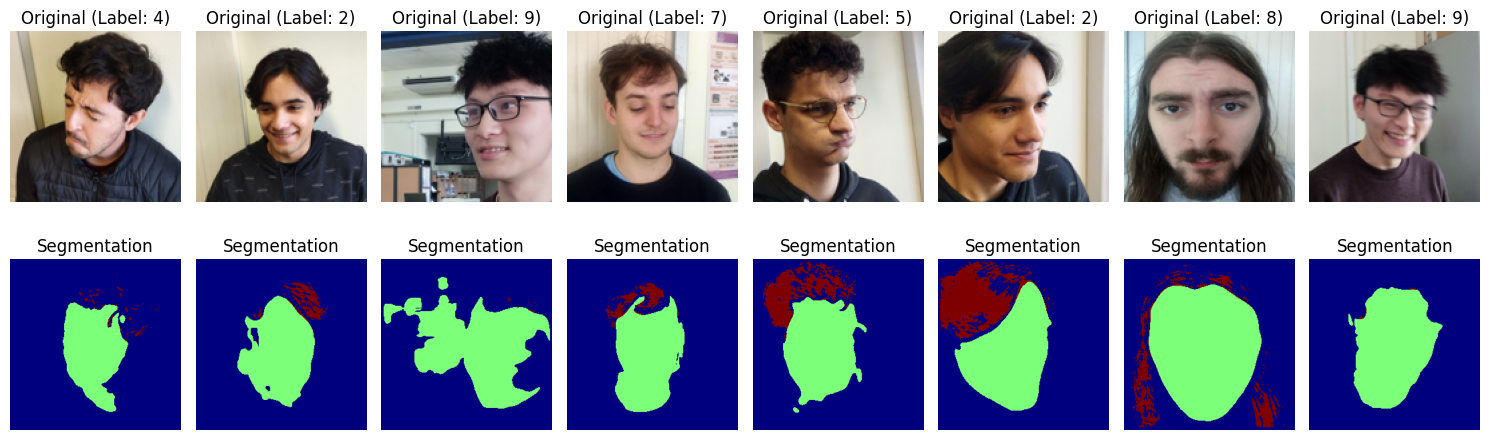

In [14]:
# Test the segmentor with a batch of images from the test_loader
images, labels = next(iter(test_loader))
images = images.to(device)

# Normalize the images for the segmentor
mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)
normalized_images = (images + 1.0) / 2.0  # Scale from [-1, 1] to [0, 1]
normalized_images = (normalized_images - mean) / std

# Resize the images to the target size (512x512)
resized_images = F.interpolate(normalized_images, size=(256, 256), mode='bilinear', align_corners=False)

# Pass the resized images through the segmentor
with torch.no_grad():
    outputs = segmentor(resized_images)

    # Extract the segmentation logits
    seg_logits = outputs[0] if isinstance(outputs, (list, tuple)) else outputs

    # Get the segmentation map by taking the argmax
    seg_map = seg_logits.argmax(dim=1).cpu().numpy()

# Visualize the original images and their corresponding segmentation maps
n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    # Original image
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    # Segmentation map
    axs[1, i].imshow(seg_map[i], cmap="jet")
    axs[1, i].set_title("Segmentation")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

## FSGAN Landmarks

In [15]:
import os
import torch
from fsgan.hrnet import hrnet_wlfw

def strip_module_prefix(state_dict):
    new = {}
    for k, v in state_dict.items():
        new_k = k[7:] if k.startswith('module.') else k
        new[new_k] = v
    return new

def load_hr18_landmarks(model_path, device=None, strict=True):
    assert os.path.exists(model_path), f"Model file not found: {model_path}"
    device = torch.device("cuda" if torch.cuda.is_available() and (device is None or str(device).startswith("cuda")) else "cpu") \
             if device is None else torch.device(device)

    # instantiate model
    model = hrnet_wlfw().to(device)

    # load checkpoint
    ckpt = torch.load(model_path, map_location=device)

    # extract state_dict whether ckpt is { 'state_dict': ... } or a raw state_dict
    if isinstance(ckpt, dict) and 'state_dict' in ckpt:
        state_dict = ckpt['state_dict']
    else:
        state_dict = ckpt

    # sometimes keys are saved with "module." prefix
    if any(k.startswith('module.') for k in state_dict.keys()):
        state_dict = strip_module_prefix(state_dict)

    # try loading (fallback to strict=False on failure)
    try:
        model.load_state_dict(state_dict, strict=strict)
    except RuntimeError as e:
        # try again with strict=False to allow minor mismatches
        print("Strict load failed, retrying with strict=False. Error:", e)
        model.load_state_dict(state_dict, strict=False)

    model.eval()
    return model

# Example usage:
# model = load_hr18_landmarks("weights/hr18_wflw_landmarks.pth")
# print(model)

In [ ]:
import torch, gc


del resized_images

# 2) free Python garbage and sync CUDA
torch.cuda.synchronize()
gc.collect()

# 3) release cached GPU memory
torch.cuda.empty_cache()

In [16]:
model_path = "weights/hr18_wflw_landmarks.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# pass the path as pretrained so model.init_weights will load keys that match
model = hrnet_wlfw(pretrained=model_path)
model.eval()

HighResolutionNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (sf): Softmax(dim=1)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=Tr

c:\dev\ProjetImage\Face-Swap-M2\.venv\lib\site-packages\torch\functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4319.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


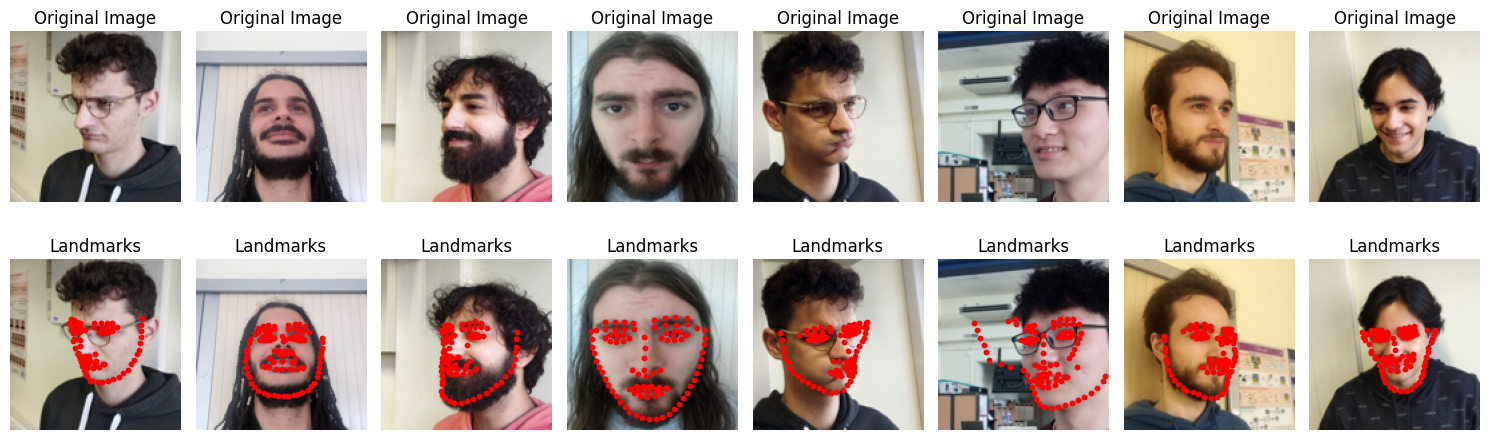

In [17]:
import torch
import torch.nn.functional as F
from fsgan.hrnet import hrnet_wlfw            # correct import
from fsgan.landmarks_utils import LandmarksHeatMapEncoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load model + weights
model = hrnet_wlfw().to(device).eval()
state = torch.load('fsgan/weights/hr18_wflw_landmarks.pth', map_location=device)
if isinstance(state, dict) and 'state_dict' in state: state = state['state_dict']
state = {k[7:]: v for k, v in state.items()} if next(iter(state)).startswith('module.') else state
model.load_state_dict(state, strict=False)

# batch
images, _ = next(iter(test_loader))         # images in [-1,1] or [0,1]
images = images.to(device)

# preprocess for HRNet: 256 and ImageNet norm
imgs = images
if imgs.min() < 0:                          # if in [-1,1], bring to [0,1]
    imgs = (imgs + 1.0) / 2.0
mean = torch.tensor([0.485,0.456,0.406], device=device).view(1,3,1,1)
std  = torch.tensor([0.229,0.224,0.225], device=device).view(1,3,1,1)
imgs = F.interpolate(imgs, size=(256,256), mode='bilinear', align_corners=False)
imgs = (imgs - mean) / std

# forward
with torch.no_grad():
    H = model(imgs)                         # (B,98,64,64) heatmaps
    enc = LandmarksHeatMapEncoder(size=H.shape[-1]).to(device)
    L = enc(H)                              # (B,98,2) in [0,1]
    # fallback if encoder zeroes out
    flat = H.view(H.shape[0], H.shape[1], -1); idx = flat.argmax(2)
    xs_arg = (idx % H.shape[-1]).float() / H.shape[-1]
    ys_arg = (idx // H.shape[-1]).float() / H.shape[-1]
    deg = ((H.view(H.shape[0], H.shape[1], -1).max(-1).values - H.view(H.shape[0], H.shape[1], -1).min(-1).values) < 1e-5)
    if deg.any():
        b, c = deg.nonzero(as_tuple=True)
        L[b, c, 0] = xs_arg[b, c]; L[b, c, 1] = ys_arg[b, c]

# L now contains valid normalized landmark coords (multiply by 256 for pixels)

# Visualize the results
n = min(8, images.size(0))  # Number of images to display
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    # Original image
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original Image")
    axs[0, i].axis("off")

    # Landmarks
    landmarks = L[i].cpu().numpy() * 128  # Scale normalized coords to pixel values
    axs[1, i].imshow(img_disp)
    axs[1, i].scatter(landmarks[:, 0], landmarks[:, 1], c="red", s=10)
    axs[1, i].set_title("Landmarks")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

## reenactment

In [52]:
import torch
from fsgan.res_unet import MultiScaleResUNet

def load_msrunet(weights_path, device):
    ckpt = torch.load(weights_path, map_location=device)
    if isinstance(ckpt, dict) and 'state_dict' in ckpt:
        state_dict = ckpt['state_dict']
    else:
        state_dict = ckpt

    # Retirer éventuel préfixe 'module.'
    cleaned = {}
    for k,v in state_dict.items():
        nk = k[7:] if k.startswith('module.') else k
        cleaned[nk] = v

    # Déterminer nombre d'enhancers
    n_local = 0
    while True:
        n_local += 1
        key_probe = f'enhancer{n_local}.in_conv.1.weight'
        if key_probe not in cleaned:
            n_local -= 1
            break
    # Si aucun enhancer trouvé => 1 par défaut (poids base seulement)
    if n_local == 0:
        n_local = 1

    # Déterminer in_nc à partir du premier conv d'entrée
    base_in_weight_key = None
    for k in cleaned.keys():
        if k.endswith('in_conv.1.weight') and k.startswith('base'):
            base_in_weight_key = k
            break
    if base_in_weight_key is None:
        # fallback: premier poids conv trouvé
        for k in cleaned.keys():
            if k.endswith('.weight') and cleaned[k].dim() == 4:
                base_in_weight_key = k
                break
    in_nc = cleaned[base_in_weight_key].shape[1]

    # Déterminer ngf à partir du premier enhancer ou de la base
    # Chercher le premier poids d'entrée d'un enhancer
    ngf = 64  # valeur par défaut
    enhancer_key = f'enhancer1.in_conv.1.weight' if n_local > 0 else None
    if enhancer_key and enhancer_key in cleaned:
        # Le ngf est le nombre de canaux de sortie du premier conv de l'enhancer1
        ngf = cleaned[enhancer_key].shape[0]
    else:
        # Sinon, déduire depuis la base
        # Le base.in_conv produit ngf_global canaux
        # ngf_global = ngf * (2 ** n_local_enhancers)
        base_first_conv_out = cleaned['base.in_conv.1.weight'].shape[0]
        ngf = base_first_conv_out // (2 ** n_local) if n_local > 0 else base_first_conv_out

    # Déterminer out_nc via dernière couche
    out_nc = 3  # par convention
    
    # Instancier modèle avec les bons paramètres
    model = MultiScaleResUNet(
        in_nc=in_nc, 
        out_nc=out_nc, 
        ngf=ngf,  # Important: utiliser le ngf correct!
        n_local_enhancers=n_local
    ).to(device)
    
    model.load_state_dict(cleaned, strict=False)
    model.eval()
    print(f"Loaded MultiScaleResUNet: in_nc={in_nc}, out_nc={out_nc}, ngf={ngf}, enhancers={n_local}")
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
reenactment_weights = "fsgan/weights/ijbc_msrunet_256_2_0_reenactment_v1.pth"
reenactment_model = load_msrunet(reenactment_weights, device)

Loaded MultiScaleResUNet: in_nc=71, out_nc=3, ngf=128, enhancers=1


Pair 1:
  Input shape: torch.Size([1, 71, 256, 256])
  Source range: [-0.96, 1.00]
  Heatmaps range: [0.00, 1.00]
  Output range: [-0.99, 0.96]
Pair 2:
  Input shape: torch.Size([1, 71, 256, 256])
  Source range: [-0.99, 1.00]
  Heatmaps range: [0.00, 1.00]
  Output range: [-1.00, 1.00]
Pair 3:
  Input shape: torch.Size([1, 71, 256, 256])
  Source range: [-1.00, 1.00]
  Heatmaps range: [0.00, 1.00]
  Output range: [-0.97, 0.93]
Pair 4:
  Input shape: torch.Size([1, 71, 256, 256])
  Source range: [-1.00, 0.93]
  Heatmaps range: [0.00, 1.00]
  Output range: [-0.98, 0.92]


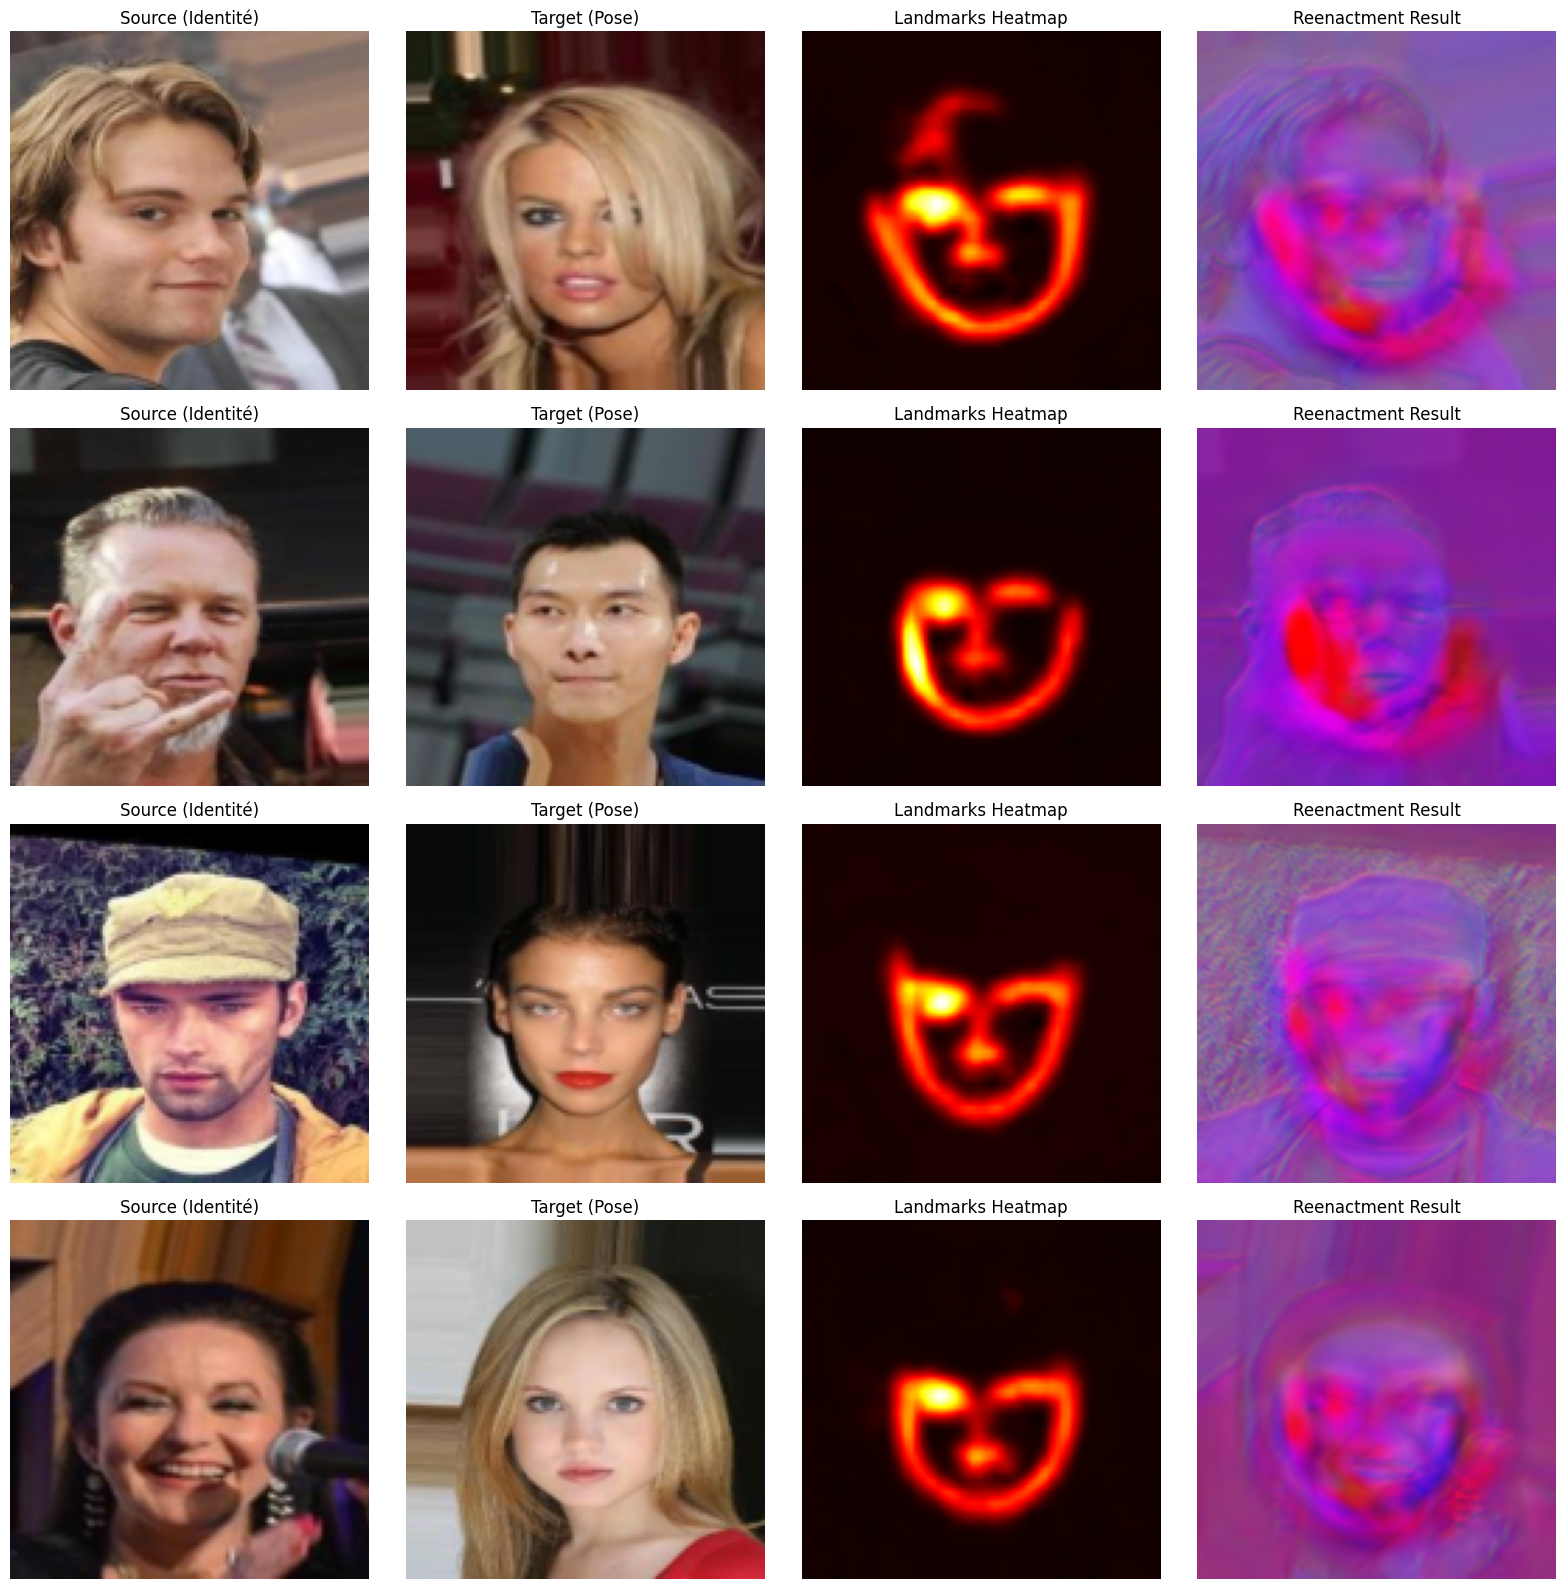


Test terminé avec 4 paires d'images


In [55]:
# Test du modèle de reenactment FSGAN - VERSION AMÉLIORÉE
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Récupérer un batch d'images
batch_images, _ = next(iter(test_loader))
batch_images = batch_images.to(device)

# Prendre 4 paires d'images (source, target)
n_pairs = min(4, batch_images.size(0) // 2)
fig, axs = plt.subplots(n_pairs, 4, figsize=(16, 4 * n_pairs))
if n_pairs == 1:
    axs = axs.reshape(1, -1)

for i in range(n_pairs):
    # Source (identité) et Target (pose)
    source = batch_images[i * 2:i * 2 + 1]      # (1, 3, 128, 128)
    target = batch_images[i * 2 + 1:i * 2 + 2]  # (1, 3, 128, 128)
    
    # Convertir de [-1,1] vers [0,1]
    source_01 = torch.clamp((source + 1.0) / 2.0, 0, 1)
    target_01 = torch.clamp((target + 1.0) / 2.0, 0, 1)
    
    # Redimensionner à 256x256 pour le modèle
    source_256 = F.interpolate(source_01, size=(256, 256), mode='bilinear', align_corners=False)
    target_256 = F.interpolate(target_01, size=(256, 256), mode='bilinear', align_corners=False)
    
    # Préparer la target pour extraire les landmarks
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)
    target_prep = (target_256 - mean) / std
    
    # Extraire les landmarks de la target (pose)
    with torch.no_grad():
        target_heatmaps = model(target_prep)  # (1, 98, 64, 64)
        
        # Prendre seulement les 68 premiers landmarks
        target_heatmaps_68 = target_heatmaps[:, :68, :, :]  # (1, 68, 64, 64)
        
        # Redimensionner les heatmaps à 256x256
        target_heatmaps_resized = F.interpolate(target_heatmaps_68, size=(256, 256), mode='bilinear', align_corners=False)
        
        # NORMALISATION IMPORTANTE : Les heatmaps doivent être normalisées
        # Normaliser chaque heatmap individuellement
        B, C, H, W = target_heatmaps_resized.shape
        heatmaps_normalized = torch.zeros_like(target_heatmaps_resized)
        for b in range(B):
            for c in range(C):
                hm = target_heatmaps_resized[b, c]
                hm_min = hm.min()
                hm_max = hm.max()
                if hm_max > hm_min:
                    heatmaps_normalized[b, c] = (hm - hm_min) / (hm_max - hm_min)
                else:
                    heatmaps_normalized[b, c] = hm
    
    # Concaténer source RGB + target heatmaps
    # Source doit être en [-1,1] pour le modèle
    source_256_normalized = source_256 * 2 - 1  # [0,1] -> [-1,1]
    reenactment_input = torch.cat([source_256_normalized, heatmaps_normalized], dim=1)
    
    print(f"Pair {i+1}:")
    print(f"  Input shape: {reenactment_input.shape}")
    print(f"  Source range: [{source_256_normalized.min():.2f}, {source_256_normalized.max():.2f}]")
    print(f"  Heatmaps range: [{heatmaps_normalized.min():.2f}, {heatmaps_normalized.max():.2f}]")
    
    # Passer dans le modèle de reenactment
    with torch.no_grad():
        result = reenactment_model(reenactment_input)
        
        # Si le modèle retourne une liste/tuple, prendre le dernier élément
        if isinstance(result, (list, tuple)):
            result = result[-1]
    
    print(f"  Output range: [{result.min():.2f}, {result.max():.2f}]")
    
    # Convertir pour affichage
    source_disp = source_01[0].permute(1, 2, 0).cpu().numpy()
    target_disp = target_01[0].permute(1, 2, 0).cpu().numpy()
    result_disp = torch.clamp((result[0] + 1.0) / 2.0, 0, 1).permute(1, 2, 0).cpu().numpy()
    
    # Visualiser aussi les heatmaps moyens pour debug
    heatmap_viz = heatmaps_normalized[0].mean(dim=0).cpu().numpy()
    
    # Affichage
    axs[i, 0].imshow(source_disp)
    axs[i, 0].set_title("Source (Identité)")
    axs[i, 0].axis("off")
    
    axs[i, 1].imshow(target_disp)
    axs[i, 1].set_title("Target (Pose)")
    axs[i, 1].axis("off")
    
    axs[i, 2].imshow(heatmap_viz, cmap='hot')
    axs[i, 2].set_title("Landmarks Heatmap")
    axs[i, 2].axis("off")
    
    axs[i, 3].imshow(result_disp)
    axs[i, 3].set_title("Reenactment Result")
    axs[i, 3].axis("off")

plt.tight_layout()
plt.show()

print(f"\nTest terminé avec {n_pairs} paires d'images")

In [ ]:
# Tester avec 4 paires différentes
n_pairs = 2
fig, axs = plt.subplots(n_pairs, 3, figsize=(12, 4*n_pairs))

for i in range(n_pairs):
    if i*2+1 >= images.size(0):
        break
    
    source = images[i*2:i*2+1].to(device)
    target = images[i*2+1:i*2+2].to(device)
    
    # Processing (comme avant)
    source_01 = (source + 1.0) / 2.0
    target_01 = (target + 1.0) / 2.0
    source_256 = F.interpolate(source_01, size=(256, 256), mode='bilinear', align_corners=False)
    target_256 = F.interpolate(target_01, size=(256, 256), mode='bilinear', align_corners=False)
    
    target_prep = (target_256 - mean) / std
    with torch.no_grad():
        target_lm = landmarks_model(target_prep)
        target_lm = F.interpolate(target_lm, size=(256, 256), mode='bilinear', align_corners=False)
    
    input_t = torch.cat([source_256 * 2 - 1, target_lm], dim=1)
    
    with torch.no_grad():
        out = model(input_t)
        if isinstance(out, (list, tuple)):
            out = out[-1]
    
    # Display
    axs[i, 0].imshow(np.clip((source[0].permute(1,2,0).cpu().numpy() + 1) / 2, 0, 1))
    axs[i, 0].set_title("Source ID")
    axs[i, 0].axis("off")
    
    axs[i, 1].imshow(np.clip((target[0].permute(1,2,0).cpu().numpy() + 1) / 2, 0, 1))
    axs[i, 1].set_title("Target Pose")
    axs[i, 1].axis("off")
    
    out_disp = np.clip((out[0].permute(1,2,0).cpu().numpy() + 1) / 2, 0, 1)
    axs[i, 2].imshow(out_disp)
    axs[i, 2].set_title("Reenacted")
    axs[i, 2].axis("off")

plt.tight_layout()
plt.show()

## Entrainement

In [ ]:
def Conv(in_ch, out_ch, norm=True):
    layers = [
        nn.Conv2d(in_ch, out_ch, 4, 2, 1),
        nn.LeakyReLU(0.2, inplace=True)
    ]
    if norm:
        layers.append(nn.InstanceNorm2d(out_ch))
    return nn.Sequential(*layers)

def Deconv(in_ch, out_ch, norm=True):
    layers = [
        nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1),
        nn.ReLU(inplace=True)
    ]
    if norm:
        layers.append(nn.InstanceNorm2d(out_ch))
    return nn.Sequential(*layers)

class VGGPerceptual(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_FEATURES).features
        self.slice = nn.Sequential(*vgg[:16])
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x, y):
        return F.l1_loss(self.slice(x), self.slice(y))


In [ ]:
class SwapGenerator(nn.Module):
    def __init__(self, id_dim=128):
        super().__init__()

        # ---------- Encoder (Structure/Attribute Extractor) ----------
        self.enc1 = Conv(3,   64, norm=False)  # 128 → 64
        self.enc2 = Conv(64, 128)              # 64 → 32
        self.enc3 = Conv(128,256)              # 32 → 16
        self.enc4 = Conv(256,512)              # 16 → 8

        # ---------- Identity Encoder (Project embedding to feature space) ----------
        self.id_encoder = nn.Sequential(
            nn.Linear(id_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 512 * 8 * 8)
        )

        # ---------- Fusion Layer ----------
        self.fusion = nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=1),  # 512 (structure) + 512 (identity)
            nn.InstanceNorm2d(512),
            nn.ReLU()
        )

        # ---------- Decoder ----------
        self.dec1 = Deconv(512,256)            # 8 → 16
        self.dec2 = Deconv(256,128)            # 16 → 32
        self.dec3 = Deconv(128, 64)            # 32 → 64
        self.dec4 = Deconv(64, 32)             # 64 → 128

        self.out = nn.Sequential(
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, img, id_emb):
        # ----- Encode Structure/Attributes -----
        e1 = self.enc1(img)   # 64
        e2 = self.enc2(e1)    # 32
        e3 = self.enc3(e2)    # 16
        e4 = self.enc4(e3)    # 8 x [B, 512, 8, 8]

        # ----- Process Identity Embedding -----
        id_features = self.id_encoder(id_emb)  # [B, 512*8*8]
        id_features = id_features.view(-1, 512, 8, 8)  # [B, 512, 8, 8]

        # ----- Fuse Structure + Identity -----
        fused = torch.cat([e4, id_features], dim=1)  # [B, 1024, 8, 8]
        fused = self.fusion(fused)  # [B, 512, 8, 8]

        # ----- Decode (no skip connections to force using fused features) -----
        d1 = self.dec1(fused)         # 16
        d2 = self.dec2(d1)            # 32
        d3 = self.dec3(d2)            # 64
        d4 = self.dec4(d3)            # 128

        return self.out(d4)

class PatchDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            Conv(3, 64, norm=False),  
            Conv(64, 128),
            Conv(128,256),
            Conv(256,512),
            nn.Conv2d(512, 1, 3, padding=1)  # output 8×8 patch
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
G = SwapGenerator(id_dim=EMBEDDING_SIZE).to(device)
D = PatchDiscriminator().to(device)

vgg_loss = VGGPerceptual().to(device)

g_opt = torch.optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.999))
d_opt = torch.optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.999))

lambda_id  = 10  # Reduced from 50 - too high can make it ignore structure


source_class = 0


In [ ]:
import torchvision.utils as vutils

# Pick a single source image of the specified source_class
for img, label in train_loader:
    if (label == source_class).any():
        fixed_source = img[label == source_class][0:1].to(device)  # shape (1,3,128,128)
        break

# Pick a single target image (not of the source_class)
for img, label in train_loader:
    if (label != source_class).any():
        fixed_target = img[label != source_class][0:1].to(device)  # shape (1,3,128,128)
        break

with torch.no_grad():
    fixed_source_emb = faceEmbedder(fixed_source).to(device)
    fixed_target_emb = faceEmbedder(fixed_target).to(device)

def visualize_swap(epoch, generator, fixed_source, fixed_target, fixed_source_emb, fixed_target_emb):
    generator.eval()
    with torch.no_grad():
        # Swap: source identity on target structure
        swapped = generator(fixed_target, fixed_source_emb)
        # Reconstruction: target identity on target structure (should be same as target)
        reconstructed = generator(fixed_target, fixed_target_emb)
    # Show: source | target | swapped | reconstructed
    grid = torch.cat([fixed_source, fixed_target, swapped, reconstructed], dim=0)
    vutils.save_image(grid, f"swap_epoch.png", nrow=4, normalize=True)
    print(f"Saved visualization: swap_epoch_{epoch}.png")

    generator.train()


In [ ]:
# Test that embedder produces different embeddings for different identities
print("Testing embedder...")
with torch.no_grad():
    emb_src = faceEmbedder(fixed_source)
    emb_tgt = faceEmbedder(fixed_target)
    
    dist = torch.dist(emb_src, emb_tgt).item()
    print(f"Distance between source and target embeddings: {dist:.4f}")
    print(f"Source embedding norm: {emb_src.norm().item():.4f}")
    print(f"Target embedding norm: {emb_tgt.norm().item():.4f}")
    
    if dist < 0.1:
        print("WARNING: Embeddings are very similar! Embedder may not be trained properly.")
    else:
        print("Good: Embeddings are sufficiently different.")


In [ ]:
for epoch in range(10000):
    for imgs, labels in train_loader:

        imgs, labels = imgs.to(device), labels.to(device)
        
        # Get batch size
        bs = imgs.size(0)
        if bs < 2:
            continue
            
        # Split batch in half: first half as source, second half as target
        mid = bs // 2
        src = imgs[:mid]
        tgt = imgs[mid:mid*2]
        
        # Ensure same batch size
        if src.size(0) != tgt.size(0):
            continue

        with torch.no_grad():
            src_emb = faceEmbedder(src)
            tgt_emb = faceEmbedder(tgt)

        # Swap: apply source identity to target image
        swapped = G(tgt, src_emb)
        
        # Reconstruction: apply target's own identity to target image (should reconstruct)
        reconstructed = G(tgt, tgt_emb)

        # --------- Train D ---------
        # Real images should be classified as real
        d_real = D(imgs)  # All real images
        d_fake = D(swapped.detach())

        d_loss = (F.mse_loss(d_real, torch.ones_like(d_real)) +
                  F.mse_loss(d_fake, torch.zeros_like(d_fake)))

        d_opt.zero_grad()
        d_loss.backward()
        d_opt.step()

        # --------- Train G ---------
        pred_fake = D(swapped)
        g_adv = F.mse_loss(pred_fake, torch.ones_like(pred_fake))

        # Identity loss: swapped image should have SOURCE identity
        swapped_emb = faceEmbedder(swapped)
        g_id = F.mse_loss(swapped_emb, src_emb)

        # Reconstruction loss: when using target's own embedding, should reconstruct target
        g_rec = F.l1_loss(reconstructed, tgt)
        
        # Optional: attribute preservation - swapped should be similar to target in structure
        g_attr = F.l1_loss(swapped, tgt) * 0.5

        g_loss = g_adv + lambda_id * g_id + g_rec * 10 + g_attr

        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

    print(f"Epoch {epoch} | D: {d_loss.item():.3f} | G: {g_loss.item():.3f} | ID: {g_id.item():.3f} | Rec: {g_rec.item():.3f}")

    if epoch % 10 == 0:
        visualize_swap(epoch, G, fixed_source, fixed_target, fixed_source_emb, fixed_target_emb)
